## Libraries Import

In [33]:
import os
# import pydub
#import sox
import pandas as pd
import numpy as np
# import datetime
# import librosa
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score

In [6]:
REPO_DIR = '/Users/JakubMichalowski/Documents/UWR/UWrMLProjectAudioSeg/'

## Pre-processed data loading

In [7]:
data = pd.concat([pd.read_csv(REPO_DIR + "/data/data_{}.csv".format(i), index_col=False) for i in [1,2,3]])
data.drop('Unnamed: 0', axis=1, inplace=True)
data.drop('timestamp', axis=1, inplace=True)

In [8]:
# data.label.unique()
data.head(7)

,label,chroma_stft,rmse,spec_cent,spec_bw,rolloff,zcr,mfcc_0,mfcc_1,mfcc_2,...,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19
0,music,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1131.370972,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,music,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1131.370972,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,music,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1131.370972,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,music,0.012444,0.081449,432.529692,424.989395,949.418501,0.014660,-632.946411,12.773681,-1.715082,...,-2.038454,-0.884550,-1.802255,0.243648,-0.727257,0.287844,0.141726,-0.364878,-0.763656,-0.566740
4,music,0.172535,0.435161,2309.434221,2392.904163,4963.403320,0.102350,-33.924923,96.108818,-15.746825,...,-10.182379,-11.484722,-13.531470,-5.707917,-9.890487,-1.513985,-8.121307,-4.673933,-4.060278,-2.206214
5,music,0.157657,0.336784,2567.839539,2600.708755,5628.485662,0.119984,-45.499687,84.936684,-8.681884,...,-11.334825,-8.786905,-12.080547,-5.115549,-6.204822,-0.849673,-5.121214,0.046853,-1.955851,-2.410228
6,music,0.163854,0.356565,2282.280482,2313.616205,4751.007635,0.108554,-50.080624,97.172562,-16.078642,...,-12.691456,-9.263289,-13.510224,-5.936949,-7.081617,-0.348157,-5.191010,-2.328905,-1.093816,-1.405749


## Data for classsifiers' training

In [27]:
X = data.drop('label', axis=1)
y = data['label']

X_ = X.copy()
y_ = y.copy()

X_, y_ = map(np.array, [X_, y_]) 

np.reshape(X_, X_.shape, order='C')
np.reshape(y_, y_.shape, order='C')

X_ = X_.astype('float32')

X_train, X_test, Y_train, Y_test = train_test_split(X_, y_, test_size = 0.3, random_state=42, shuffle=False)
# trainX, testX, trainY, testY = map(np.array, [trainX, testX, trainY, testY]) 

# train_X = trainX.copy() 
# test_X  = testX.copy()
# train_y = trainY.copy()
# test_y  = testY.copy()

# np.reshape(train_X, train_X.shape, order='C')
# np.reshape(test_X, test_X.shape, order='C')
# np.reshape(train_y, train_y.shape, order='C')
# np.reshape(test_y, test_y.shape, order='C')

# train_X = train_X.astype('float32')
# test_X = test_X.astype('float32')

In [19]:
# le = preprocessing.LabelEncoder()
# le.fit(train_y)
# test_y_trans = le.transform(test_y)
# train_y_trans = le.transform(train_y)

## Faiss library classifier

In [20]:
import faiss

class FaissKMeans:
    def __init__(self, n_clusters=8, n_redo=10, max_iter=300):
        self.n_clusters = n_clusters
        # redo means repeating with new starting points
        self.n_redo = n_redo
        self.max_iter = max_iter
        
        self.kmeans = None
        self.cluster_centers_ = None
        self.inertia_ = None

    def fit(self, X):
        self.kmeans = faiss.Kmeans(d=X.shape[1],
                                   k=self.n_clusters,
                                   niter=self.max_iter,
                                   nredo=self.n_redo)
        self.kmeans.train(X.astype(np.float32))
        self.cluster_centers_ = self.kmeans.centroids
        self.inertia_ = self.kmeans.obj[-1]

    def predict(self, X):
        preds = self.kmeans.index.search(X.astype(np.float32), 1)[1]
        preds = preds.reshape((X.shape[0], ))
        return np.array(pd.Series(preds).map({1: 'music', 0: 'speech'}))

## Sklearn classifier

In [21]:
from sklearn.cluster import KMeans

class SklearnKMeans:
    def __init__(self, n_clusters=8, n_redo=10, max_iter=300, initialization='random'):
        self.n_clusters = n_clusters
        # redo means repeating with new starting points
        self.n_redo = n_redo
        self.max_iter = max_iter
        self.initialization = initialization
        
        self.kmeans = None
        self.cluster_centers_ = None
#         self.inertia_ = None

    def fit(self, X):
        self.kmeans = KMeans(n_clusters=self.n_clusters, 
                             random_state=0, 
                             init=self.initialization, 
                             n_init=self.n_redo, max_iter=self.max_iter)
        
        self.kmeans.fit(X)
        self.cluster_centers_ = self.kmeans.cluster_centers_

    def predict(self, X):
        preds = self.kmeans.predict(X)
        preds = preds.reshape((X.shape[0], ))
        return np.array(pd.Series(preds).map({0: 'music', 1: 'speech'}))

## Fitting classifiers on the complete dataset

In [28]:
K  = 2

kmeansFaiss = FaissKMeans(n_clusters=K, max_iter=300, n_redo=50)
kmeansFaiss.fit(X_train)
y_pred_faiss_train = kmeansFaiss.predict(X_train)
y_pred_faiss_test = kmeansFaiss.predict(X_test)


# initialization_methods = ['random', 'k-means++']
# for init_method in initialization_methods:
#     pass
kmeansSklearn = SklearnKMeans(n_clusters=K, initialization='random', n_redo=50)
kmeansSklearn.fit(X_train)
y_pred_sklearn_train = kmeansSklearn.predict(X_train)
y_pred_sklearn_test = kmeansSklearn.predict(X_test)

In [29]:
# y_pred_sklearn_train = np.array(pd.Series(y_pred_sklearn_train).map({0: 'music', 1: 'speech'}))
# y_pred_sklearn_test = np.array(pd.Series(y_pred_sklearn_test).map({0: 'music', 1: 'speech'}))

In [30]:
trainAccuracies = {
    'sklearn': accuracy_score(y_true=train_Y, y_pred=y_pred_sklearn_train),
    'faiss': accuracy_score(y_true=train_Y, y_pred=y_pred_faiss_train)
}
trainAccuracies

{'sklearn': 0.7138749101365924, 'faiss': 0.7233165588305775}

In [31]:
testAccuracies = {
    'sklearn': accuracy_score(y_true=test_Y, y_pred=y_pred_sklearn_test),
    'faiss': accuracy_score(y_true=test_Y, y_pred=y_pred_faiss_test)
}
testAccuracies

{'sklearn': 0.724029967572403, 'faiss': 0.7354355361735435}

## Fitting on different number of principal components//

In [80]:
faiss_train_accuracies = []
sklearn_train_accuracies = []

faiss_test_accuracies = []
sklearn_test_accuracies = []

faiss_train_accuracies_dict = {}
sklearn_train_accuracies_dict = {}

faiss_test_accuracies_dict = {}
sklearn_test_accuracies_dict = {}

K = 2
n_features = data.shape[1]  # We have 26 features.
principal_components = np.arange(10, n_features, 1)

for principal_component in tqdm(principal_components):
    pca = PCA(n_components=principal_component)
    # use fit_transform to run PCA on our standardized matrix
    X_pcaed = pca.fit_transform(X_)
#     print(X_pcaed.shape)
    trainX, testX, trainY, testY = train_test_split(
        X_pcaed, y_, test_size = 0.3, shuffle=False)
    
    kmeansFaiss = FaissKMeans(n_clusters=K, max_iter=300, n_redo=50)
    kmeansFaiss.fit(trainX)
    y_pred_faiss_train = kmeansFaiss.predict(trainX)
    y_pred_faiss_test = kmeansFaiss.predict(testX)
    faiss_train_accuracies.append(
        accuracy_score(y_true=trainY, y_pred=y_pred_faiss_train))
    faiss_test_accuracies.append(
        accuracy_score(y_true=testY, y_pred=y_pred_faiss_test))
    faiss_train_accuracies_dict[str(principal_component)] = accuracy_score(y_true=trainY, y_pred=y_pred_faiss_train)
    faiss_test_accuracies_dict[str(principal_component)] = accuracy_score(y_true=testY, y_pred=y_pred_faiss_test)    
    kmeansSklearn = SklearnKMeans(n_clusters=K, initialization='random', n_redo=50)
    kmeansSklearn.fit(trainX)
    y_pred_sklearn_train = kmeansSklearn.predict(trainX)
    y_pred_sklearn_test = kmeansSklearn.predict(testX)
    
    curr_train_acc = accuracy_score(y_true=trainY, y_pred=y_pred_sklearn_train)
    if curr_train_acc < 0.35:
        curr_train_acc = 1 - curr_train_acc
    curr_test_acc = accuracy_score(y_true=testY, y_pred=y_pred_sklearn_test)
    if curr_test_acc < 0.35:
        curr_test_acc = 1 - curr_test_acc
    
    sklearn_train_accuracies.append(curr_train_acc)
    sklearn_test_accuracies.append(curr_test_acc)
    sklearn_train_accuracies_dict[str(principal_component)] = curr_train_acc
    sklearn_test_accuracies_dict[str(principal_component)] = curr_test_acc
#     sklearn_train_accuracies.append(
#         accuracy_score(y_true=trainY, y_pred=y_pred_sklearn_train))
#     sklearn_test_accuracies.append(
#         accuracy_score(y_true=testY, y_pred=y_pred_sklearn_test))

In [81]:
# TODO inspect the class FaissKmeans’s predict method becuase accuracy always returns the same output even if the number of principal components is different.

print('Faiss train accuracies:')
print(faiss_train_accuracies_dict)

Faiss train accuracies:
{'10': 0.7233165588305775, '11': 0.7233165588305775, '12': 0.7233165588305775, '13': 0.7233165588305775, '14': 0.7233165588305775, '15': 0.7233165588305775, '16': 0.7233165588305775, '17': 0.7233165588305775, '18': 0.7233165588305775, '19': 0.7233165588305775, '20': 0.7233165588305775, '21': 0.7233165588305775, '22': 0.7233165588305775, '23': 0.7233165588305775, '24': 0.7233165588305775, '25': 0.7233165588305775, '26': 0.7233165588305775}


In [82]:
print('Faiss test accuracies:')
print(faiss_test_accuracies_dict)

Faiss test accuracies:
{'10': 0.7354355361735435, '11': 0.7354355361735435, '12': 0.7354355361735435, '13': 0.7354355361735435, '14': 0.7354355361735435, '15': 0.7354355361735435, '16': 0.7354355361735435, '17': 0.7354355361735435, '18': 0.7354355361735435, '19': 0.7354355361735435, '20': 0.7354355361735435, '21': 0.7354355361735435, '22': 0.7354355361735435, '23': 0.7354355361735435, '24': 0.7354355361735435, '25': 0.7354355361735435, '26': 0.7354355361735435}


In [83]:
print('Sklearn train accuracies:')
print(sklearn_train_accuracies_dict)

Sklearn train accuracies:
{'10': 0.714881380301941, '11': 0.7146896716990174, '12': 0.7145938173975557, '13': 0.7145938173975557, '14': 0.7145938173975557, '15': 0.7145938173975557, '16': 0.7147855260004793, '17': 0.7145458902468248, '18': 0.7145458902468248, '19': 0.7145458902468248, '20': 0.7145458902468248, '21': 0.7144979630960939, '22': 0.7144979630960939, '23': 0.7144979630960939, '24': 0.7144979630960939, '25': 0.7144979630960939, '26': 0.7138749101365924}


In [84]:
print('Sklearn test accuracies:')
print(sklearn_test_accuracies_dict)

Sklearn test accuracies:
{'10': 0.7242536061724254, '11': 0.7242536061724254, '12': 0.7244772447724477, '13': 0.7244772447724477, '14': 0.7244772447724477, '15': 0.7244772447724477, '16': 0.7242536061724254, '17': 0.7243654254724365, '18': 0.7243654254724365, '19': 0.7243654254724365, '20': 0.7243654254724365, '21': 0.7243654254724365, '22': 0.7243654254724365, '23': 0.7243654254724365, '24': 0.7243654254724365, '25': 0.7243654254724365, '26': 0.724029967572403}


## Accuracy Plots

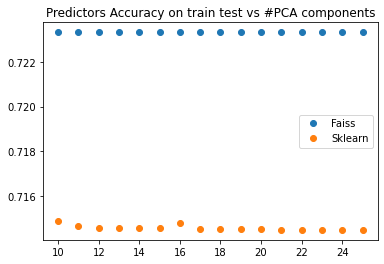

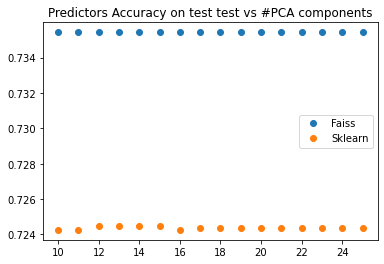

In [77]:
plt.plot(principal_components, faiss_train_accuracies, 'o')
plt.plot(principal_components, sklearn_train_accuracies, 'o')
plt.legend(['Faiss', 'Sklearn'])
plt.title('Predictors Accuracy on train test vs #PCA components')
plt.show()

plt.plot(principal_components, faiss_test_accuracies, 'o')
plt.plot(principal_components, sklearn_test_accuracies, 'o')
plt.legend(['Faiss', 'Sklearn'])
plt.title('Predictors Accuracy on test test vs #PCA components')
plt.show()


## Smoothing HHM

In [20]:
from pomegranate import HiddenMarkovModel
from pomegranate.distributions import DiscreteDistribution
import pomegranate as pg

class smoothHMM:

    def __init__(self, predictor, state_names):

        self.predictor = predictor
        self.modelHMM = HiddenMarkovModel()
        self.le=LabelEncoder()
        self.state_names = state_names

    def fit(self, X, y):
        
        X, y = map(np.array, [X, y])
        X_ = X.copy() 
        y_ = y.copy()
        
        np.reshape(X_, X_.shape, order='C')
        np.reshape(y_, y_.shape, order='C')
        
        X_ = X_.astype('float32')
        
        X_simplified = self.le.fit_transform(self.predictor.predict(X_)).reshape(1, -1)
        y_simplified = y_.reshape(1, -1)
    
        self.modelHMM = self.modelHMM.from_samples(
            DiscreteDistribution, len(self.state_names), X_simplified, labels = y_simplified,
            algorithm='labeled', state_names=self.state_names , verbose = True)
        self.modelHMM.bake()
           

    def predict(self, X):
        
        X= np.array(X)
        X_ = X.copy()
        
        np.reshape(X_, X_.shape, order='C')    
        X_ = X_.astype('float32')
            
        X_simplified = self.le.transform(self.predictor.predict(X_)).tolist()
        return self.modelHMM.predict(X_simplified)
    
    def score(self, X, y):
        
        target = self.predict(X)    
        y = self.le.transform(y.to_numpy())
        
        return np.sum(target==y)/y.shape[0]

## Test data Load

In [21]:
dataHTrain = pd.concat([pd.read_csv(REPO_DIR + "/data/data_{}.csv".format(i), index_col=False) for i in [1,2]])
dataHTrain.drop('Unnamed: 0', axis=1, inplace=True)
dataHTrain.drop('timestamp', axis=1, inplace=True)
dataHTest = pd.concat([pd.read_csv(REPO_DIR + "/data/data_{}.csv".format(i), index_col=False) for i in [3]])
dataHTest.drop('Unnamed: 0', axis=1, inplace=True)
dataHTest.drop('timestamp', axis=1, inplace=True)

In [22]:
trainHX = dataHTrain.drop('label', axis=1)
trainHY = dataHTrain['label']

testHX = dataHTest.drop('label', axis=1)
testHY = dataHTest['label']

## Performance tests

In [23]:
hmm_faiss = smoothHMM(kmeansFaiss, state_names=['music', 'speech'])
hmm_faiss.fit(trainHX, trainHY)
print('Faiss library classifier score:', hmm_faiss.score(testHX, testHY))

[1] Improvement: 4304.927336080702	Time (s): 0.0426
[2] Improvement: 0.0	Time (s): 0.03693
Total Training Improvement: 4304.927336080702
Total Training Time (s): 0.1345
Faiss library classifier score: 0.7624750499001997


In [24]:
hmm_sklearn = smoothHMM(kmeansSklearn, state_names=['music', 'speech'])
hmm_sklearn.fit(trainHX, trainHY)
print('Sklearn library classifier score:', hmm_sklearn.score(testHX, testHY))

[1] Improvement: 4282.8583965135895	Time (s): 0.05229
[2] Improvement: 0.0	Time (s): 0.03325
Total Training Improvement: 4282.8583965135895
Total Training Time (s): 0.1394
Sklearn library classifier score: 0.7572854291417166
